In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c generative-dog-images

 98% 725M/744M [00:06<00:00, 143MB/s]
100% 744M/744M [00:06<00:00, 121MB/s]


In [ ]:
!cp generative-dog-images.zip 'drive/My Drive/TIES4911/task8/'

In [ ]:
!unzip -q 'drive/My Drive/TIES4911/task8/generative-dog-images.zip' -d 'drive/My Drive/TIES4911/task8/dataset/generative-dog-images'

In [ ]:
!unzip -q 'drive/My Drive/TIES4911/task8/dataset/generative-dog-images/all-dogs.zip' -d 'drive/My Drive/TIES4911/task8/dataset/generative-dog-images/'

In [77]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa

from IPython import display

In [79]:
batch_size= 256
BATCH_SIZE=256

img_rows = 32
img_cols = 32
channels = 3

image_size = [img_rows, img_cols]
img_shape = (img_rows, img_cols, channels)


ds = image_dataset_from_directory(
    'drive/My Drive/TIES4911/task8/dataset/generative-dog-images',
    labels=None,
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)

def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image


def trans1(img):
    return tfa.image.rotate(tf.image.flip_left_right(tf.image.flip_up_down(img)),-.2,fill_mode="reflect",interpolation="bilinear")

def trans2(img):
    return tfa.image.rotate(img,-.2,fill_mode="reflect",interpolation="bilinear")

def trans3(img):
    return tfa.image.rotate(img,.2,fill_mode="reflect",interpolation="bilinear")
    
ds1,ds2,ds3,ds4 = ds,ds.map(trans1),ds.map(trans2),ds.map(trans3)

ds = ds1.concatenate(ds2).concatenate(ds3).concatenate(ds4)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = (
    ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 20579 files belonging to 1 classes.


In [80]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(100,)))
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))

    model.summary()
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               51200     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 3072)              1575936   
                                                                 
 reshape_3 (Reshape)         (None, 32, 32, 3)        

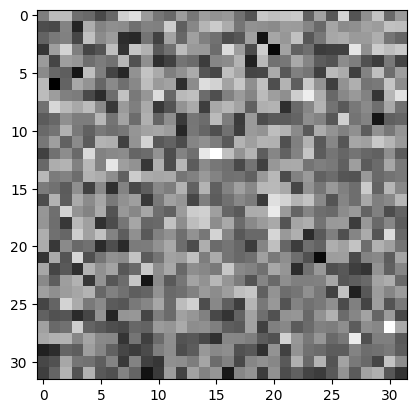

In [81]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [82]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, input_shape=img_shape))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1, activation="sigmoid"))

    model.summary()
    return model

In [83]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 32, 32, 512)       2048      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 512)       0         
                                                                 
 dense_22 (Dense)            (None, 32, 32, 256)       131328    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 dense_23 (Dense)            (None, 32, 32, 1)         257       
                                                                 
Total params: 133,633
Trainable params: 133,633
Non-trainable params: 0
_________________________________________________________________
tf.Tensor(
[[[[0.5003559 ]
   [0.50141513]
   [0

In [84]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [85]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [86]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [87]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [88]:
checkpoint_dir = 'drive/My Drive/TIES4911/task8/task82_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [89]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [90]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [91]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [92]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

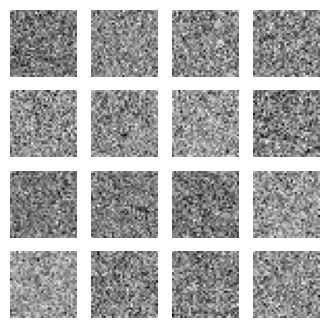

Time for epoch 6 is 2881.291737318039 sec


In [ ]:
train(train_dataset, EPOCHS)